In [1]:
# Import packages and implement notebook settings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import scipy
from sklearn.model_selection import KFold, cross_val_score
import time


kf = KFold(shuffle = True, random_state = 0)


pd.set_option('display.max_rows', 1000); pd.set_option('display.max_columns', 1000); pd.set_option('display.width', 1000)

%matplotlib inline 

sns.set_theme(style="darkgrid")


# Data Import

In [2]:
import os

current_directory = os.getcwd()

dataframes = ['features.csv', 'features_dum_drop.csv', 'features_dum_nodrop.csv', 'features_encoded.csv',
              'response.csv',
              'X_train_drop.csv', 'X_test_drop.csv', 'y_train_drop.csv', 'y_test_drop.csv',
              'X_train_nodrop.csv', 'X_test_nodrop.csv', 'y_train_nodrop.csv', 'y_test_nodrop.csv',
              'X_train_encoded.csv', 'X_test_encoded.csv', 'y_train_encoded.csv', 'y_test_encoded.csv',
              'X_train_drop_scaled.csv', 'X_test_drop_scaled.csv',
              'X_train_nodrop_scaled.csv', 'X_test_nodrop_scaled.csv']

loaded_dataframes = {}

for file_name in dataframes:
    
    df_name = file_name.split('.csv')[0]
    file_path = os.path.join(current_directory, file_name)
    loaded_dataframes[df_name] = pd.read_csv(file_path, sep='\t')



In [3]:
features = loaded_dataframes['features']
features_dum_drop = loaded_dataframes['features_dum_drop']
features_dum_nodrop = loaded_dataframes['features_dum_nodrop']
features_encoded = loaded_dataframes['features_encoded']

response = loaded_dataframes['response']


X_train_drop = loaded_dataframes['X_train_drop']
X_test_drop= loaded_dataframes['X_test_drop']
y_train_drop = loaded_dataframes['y_train_drop']['SalePrice']
y_test_drop = loaded_dataframes['y_test_drop']['SalePrice']

X_train_encoded = loaded_dataframes['X_train_encoded']
X_test_encoded = loaded_dataframes['X_test_encoded']
y_train_encoded = loaded_dataframes['y_train_encoded']['SalePrice']
y_test_encoded = loaded_dataframes['y_test_encoded']['SalePrice']

# XGBoost

## XGBoost - Dummification - Base Model

In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0)


xgb.fit(X_train_drop, np.log(y_train_drop))


print('Best train score: ' + str(r2_score(np.log(y_train_drop), xgb.predict(X_train_drop))))
print('Best test score: ' + str(r2_score(np.log(y_test_drop), xgb.predict(X_test_drop))))



Best train score: 0.9987403833400618
Best test score: 0.9162476793645031


In [5]:
xgb_drop_train_test_score = pd.DataFrame({'Model': ['XGBoost_Drop'],
              'Train Score': [r2_score(np.log(y_train_drop), xgb.predict(X_train_drop))],
              'Test Score': [r2_score(np.log(y_test_drop), xgb.predict(X_test_drop))]
             })
xgb_drop_train_test_score

,Model,Train Score,Test Score
0,XGBoost_Drop,0.99874,0.916248


Text(0, 0.5, 'Actual SalePrice')

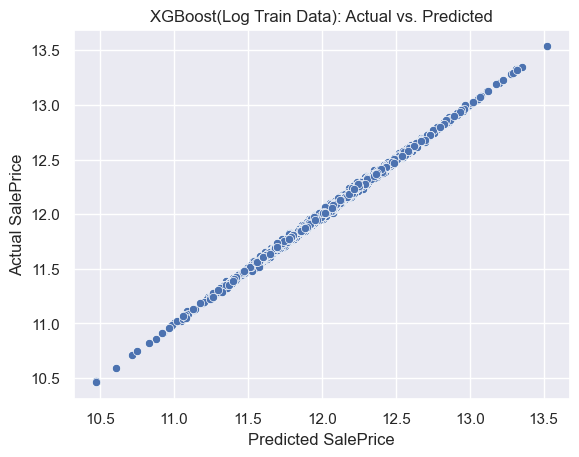

In [6]:
sns.scatterplot(x = xgb.predict(X_train_drop), y = np.log(y_train_drop))
plt.title('XGBoost(Log Train Data): Actual vs. Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Actual SalePrice')

Text(0, 0.5, 'Actual SalePrice')

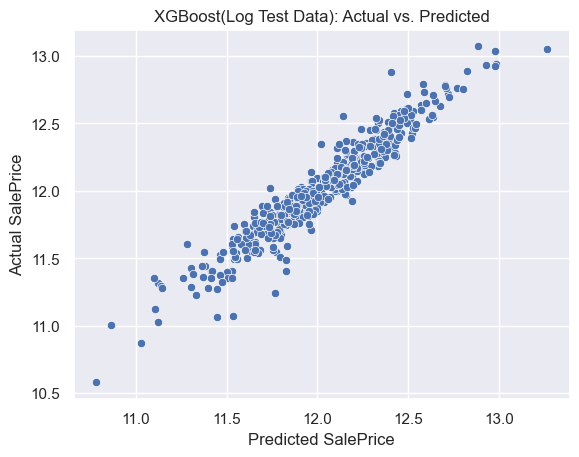

In [7]:
sns.scatterplot(x = xgb.predict(X_test_drop), y = np.log(y_test_drop))
plt.title('XGBoost(Log Test Data): Actual vs. Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Actual SalePrice')

## XGBoost - Dummification - Cross Validation

In [8]:

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0)

xgb_drop_cv = cross_val_score(estimator = xgb, X = features_dum_drop, y = np.log(response), cv = kf, scoring = 'r2')


In [9]:

print('Mean cross-validation score: ' + str(xgb_drop_cv.mean()))
print('Std dev cross-validation score: ' + str(xgb_drop_cv.std()))

Mean cross-validation score: 0.9056004590386104
Std dev cross-validation score: 0.012864703755101778


## XGBoost - Dummification - Hyperparameter Tuning

In [10]:
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0)

param = {'learning_rate': [0.033, 0.067, 0.1, 0.133, 0.167], 'subsample': [0.3, 0.6, 1],'n_estimators': [40, 50, 60]}

gsCV = GridSearchCV(xgb, param, cv = kf, return_train_score = True)
gsCV.fit(X_train_drop, np.log(y_train_drop))


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'learning_rate': [0.033, 0.067, 0.1, 0.133, 0.167],
                         'n_estimators': [40, 50, 60],
                         'subsample': [0.3, 0.6, 1]},
             return_train_score=True)

In [11]:
gsCV_xgb_train_vs_test_df = pd.DataFrame(data = {'train_score': gsCV.cv_results_['mean_train_score'],\
                                               'test_score': gsCV.cv_results_['mean_test_score']}).reset_index().rename(columns = {'index': 'model_number'})
gsCV_xgb_train_vs_test_df['model_number'] = gsCV_xgb_train_vs_test_df['model_number'] + 1
gsCV_xgb_train_vs_test_df['score_difference'] = gsCV_xgb_train_vs_test_df['train_score'] - gsCV_xgb_train_vs_test_df['test_score']

gsCV_xgb_train_vs_test_df = gsCV_xgb_train_vs_test_df.melt(id_vars = ['model_number','score_difference'], value_vars = ['train_score', 'test_score'], var_name = 'score_type', value_name = 'score')

gsCV_xgb_train_vs_test_df


,model_number,score_difference,score_type,score
0,1,0.034112,train_score,0.838208
1,2,0.051008,train_score,0.856746
2,3,0.065442,train_score,0.868260
3,4,0.037856,train_score,0.883150
4,5,0.055336,train_score,0.901166
5,6,0.071674,train_score,0.911711
6,7,0.040963,train_score,0.911092
7,8,0.058465,train_score,0.928276
8,9,0.075696,train_score,0.937859
9,10,0.047511,train_score,0.941298


<Axes: xlabel='model_number', ylabel='score'>

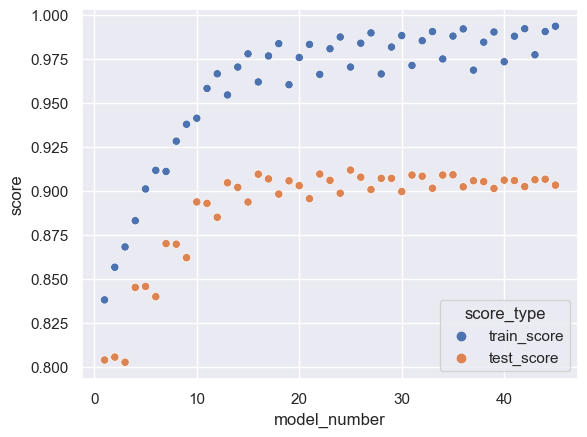

In [12]:
sns.scatterplot(data = gsCV_xgb_train_vs_test_df.loc[gsCV_xgb_train_vs_test_df['score'] > 0,:], y = 'score', x = 'model_number', hue = 'score_type')

In [13]:
print('Best score: ' + str(gsCV.best_score_))
print('Best parameters: ' + str(gsCV.best_params_))


Best score: 0.9118771982015585
Best parameters: {'learning_rate': 0.1, 'n_estimators': 60, 'subsample': 0.3}


In [14]:
xgb.set_params(learning_rate = 0.1, subsample = 0.3, n_estimators = 60)
xgb.fit(X = X_train_drop, y = np.log(y_train_drop))
print('Best train score: ' + str(xgb.score(X = X_train_drop,y = np.log(y_train_drop))))
print('Best test score: ' + str(xgb.score(X = X_test_drop,y = np.log(y_test_drop))))


Best train score: 0.9682735476336981
Best test score: 0.9202462106084498


In [15]:
xgb_drop_tuned_train_test_score = pd.DataFrame({'Model': ['XGBoost_Drop_Tuned'],
              'Train Score': [r2_score(np.log(y_train_drop), xgb.predict(X_train_drop))],
              'Test Score': [r2_score(np.log(y_test_drop), xgb.predict(X_test_drop))]
             })
xgb_drop_tuned_train_test_score

,Model,Train Score,Test Score
0,XGBoost_Drop_Tuned,0.968274,0.920246


## XGBoost - Dummification - Post Tuning - Cross Validation

In [16]:

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0, learning_rate = 0.1, subsample = 0.3, n_estimators = 60)

xgb_drop_cv_tuned = cross_val_score(estimator = xgb, X = features_dum_drop, y = np.log(response), cv = kf, scoring = 'r2')


In [17]:

print('Mean cross-validation score: ' + str(xgb_drop_cv_tuned.mean()))
print('Std dev cross-validation score: ' + str(xgb_drop_cv_tuned.std()))

Mean cross-validation score: 0.9163270093710176
Std dev cross-validation score: 0.008976747076220683


## XGBoost - Encoded - Base Model

In [18]:

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0)


xgb.fit(X_train_encoded, np.log(y_train_encoded))


print('Best train score: ' + str(r2_score(np.log(y_train_encoded), xgb.predict(X_train_encoded))))
print('Best test score: ' + str(r2_score(np.log(y_test_encoded), xgb.predict(X_test_encoded))))


Best train score: 0.9992641812121305
Best test score: 0.9137420804551395


In [19]:
xgb_encoded_train_test_score = pd.DataFrame({'Model': ['XGBoost_Encoded'],
              'Train Score': [r2_score(np.log(y_train_encoded), xgb.predict(X_train_encoded))],
              'Test Score': [r2_score(np.log(y_test_encoded), xgb.predict(X_test_encoded))]
             })
xgb_encoded_train_test_score

,Model,Train Score,Test Score
0,XGBoost_Encoded,0.999264,0.913742


<Axes: xlabel='Feature', ylabel='Importance'>

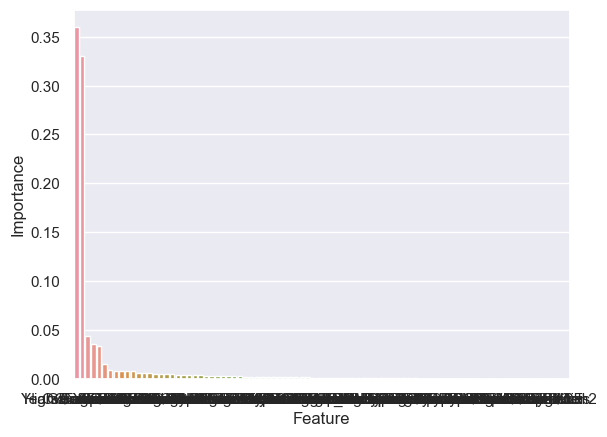

In [20]:
xgb_encoded_feature_importances = pd.Series(xgb.feature_importances_, index=X_train_encoded.columns).sort_values(ascending=False)
xgb_encoded_feature_importances = pd.DataFrame(data = xgb_encoded_feature_importances,  columns = [ 'Importance']).reset_index().rename(columns = {'index': 'Feature'})

sns.barplot(data = xgb_encoded_feature_importances, y = 'Importance', x = 'Feature')


[Text(0, 0, 'HighQualFinSF'),
 Text(1, 0, 'OverallQual'),
 Text(2, 0, 'GarageCars'),
 Text(3, 0, 'CentralAir'),
 Text(4, 0, 'Fireplaces'),
 Text(5, 0, 'TotalSF'),
 Text(6, 0, 'YearsBetweenBuildvsSold'),
 Text(7, 0, 'ExterQual'),
 Text(8, 0, 'OverallCond'),
 Text(9, 0, 'YearRemodAdd'),
 Text(10, 0, 'GarageCond'),
 Text(11, 0, 'TotalFullBath'),
 Text(12, 0, 'KitchenQual'),
 Text(13, 0, 'BsmtQual'),
 Text(14, 0, 'MSSubClass'),
 Text(15, 0, 'GarageType'),
 Text(16, 0, 'GrLivArea'),
 Text(17, 0, 'PavedDrive'),
 Text(18, 0, 'GarageArea'),
 Text(19, 0, 'SaleCondition'),
 Text(20, 0, 'KitchenAbvGr'),
 Text(21, 0, 'TotalHalfBath'),
 Text(22, 0, 'HalfBath'),
 Text(23, 0, 'Heating'),
 Text(24, 0, 'BsmtFinSF'),
 Text(25, 0, 'GarageYrBlt'),
 Text(26, 0, 'LotArea'),
 Text(27, 0, 'BedroomAbvGr'),
 Text(28, 0, 'YearBuilt'),
 Text(29, 0, 'BsmtFinType1'),
 Text(30, 0, 'RoofStyle'),
 Text(31, 0, 'LandContour'),
 Text(32, 0, 'Foundation'),
 Text(33, 0, 'YearsBetweenRemodvsSold'),
 Text(34, 0, 'BsmtUnfSF')

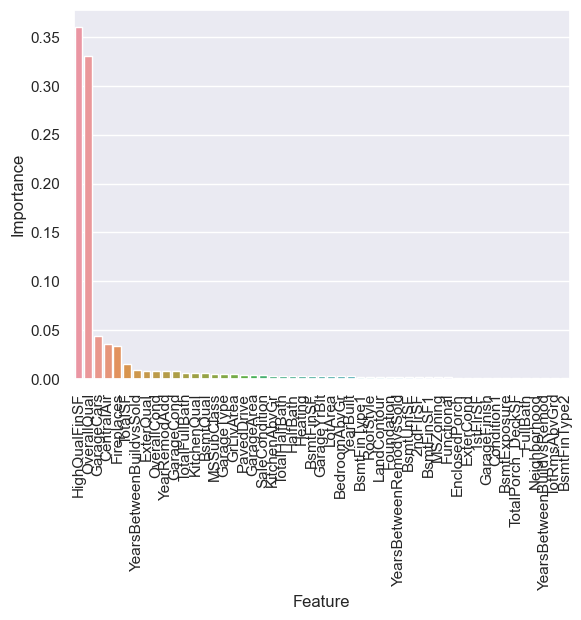

In [21]:

plot = sns.barplot(data = xgb_encoded_feature_importances.loc[xgb_encoded_feature_importances['Importance'] > 0.001, :], y = 'Importance', x = 'Feature')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)



In [22]:
def list_intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

[Text(0, 0, 'CentralAir'),
 Text(1, 0, 'ExterQual'),
 Text(2, 0, 'GarageCond'),
 Text(3, 0, 'KitchenQual'),
 Text(4, 0, 'BsmtQual'),
 Text(5, 0, 'GarageType'),
 Text(6, 0, 'PavedDrive'),
 Text(7, 0, 'SaleCondition'),
 Text(8, 0, 'Heating'),
 Text(9, 0, 'BsmtFinType1'),
 Text(10, 0, 'RoofStyle'),
 Text(11, 0, 'LandContour'),
 Text(12, 0, 'Foundation'),
 Text(13, 0, 'MSZoning'),
 Text(14, 0, 'Functional'),
 Text(15, 0, 'ExterCond'),
 Text(16, 0, 'GarageFinish'),
 Text(17, 0, 'Condition1'),
 Text(18, 0, 'BsmtExposure'),
 Text(19, 0, 'Neighborhood'),
 Text(20, 0, 'BsmtFinType2'),
 Text(21, 0, 'BldgType'),
 Text(22, 0, 'BsmtCond'),
 Text(23, 0, 'HeatingQC'),
 Text(24, 0, 'Exterior1st'),
 Text(25, 0, 'HouseStyle'),
 Text(26, 0, 'Exterior2nd'),
 Text(27, 0, 'SaleType'),
 Text(28, 0, 'MasVnrType'),
 Text(29, 0, 'FireplaceQu'),
 Text(30, 0, 'Electrical'),
 Text(31, 0, 'LotShape'),
 Text(32, 0, 'GarageQual'),
 Text(33, 0, 'Fence'),
 Text(34, 0, 'LandSlope'),
 Text(35, 0, 'LotConfig'),
 Text(36, 

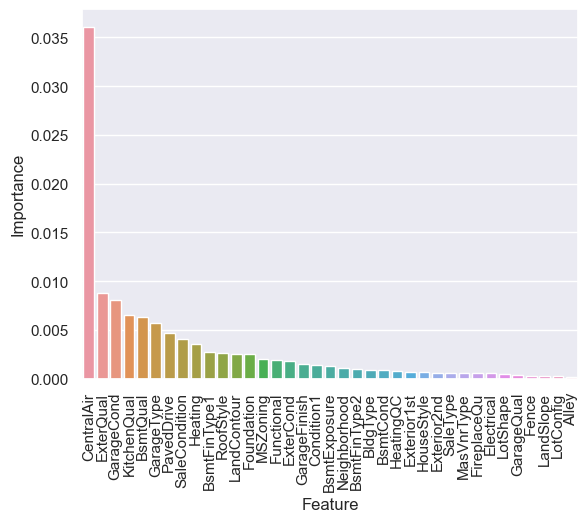

In [23]:

cat_features_col = features.select_dtypes(include=['object']).columns


plot = sns.barplot(data = xgb_encoded_feature_importances.loc[(xgb_encoded_feature_importances['Importance'] > 0.0001) & (xgb_encoded_feature_importances['Feature'].isin(list_intersection(list(xgb_encoded_feature_importances['Feature']),cat_features_col))), :], y = 'Importance', x = 'Feature')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)




Text(0, 0.5, 'Actual SalePrice')

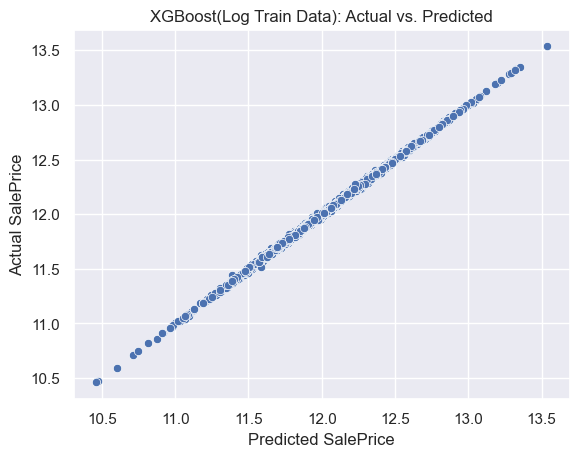

In [24]:
sns.scatterplot(x = xgb.predict(X_train_encoded), y = np.log(y_train_encoded))
plt.title('XGBoost(Log Train Data): Actual vs. Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Actual SalePrice')

Text(0, 0.5, 'Actual SalePrice')

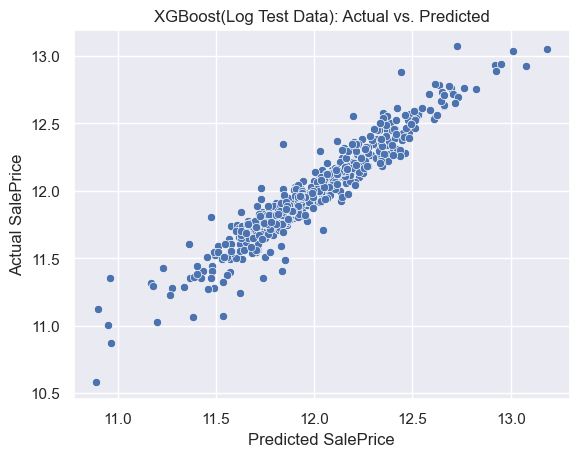

In [25]:
sns.scatterplot(x = xgb.predict(X_test_encoded), y = np.log(y_test_encoded))
plt.title('XGBoost(Log Test Data): Actual vs. Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Actual SalePrice')

## XGBoost - Encoded - Cross Validation

In [26]:

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0)

xgb_encoded_cv = cross_val_score(estimator = xgb, X = features_encoded, y = np.log(response), cv = kf, scoring = 'r2')


In [27]:

print('Mean cross-validation score: ' + str(xgb_encoded_cv.mean()))
print('Std dev cross-validation score: ' + str(xgb_encoded_cv.std()))

Mean cross-validation score: 0.9038084279100842
Std dev cross-validation score: 0.009171404036675577


## XGBoost - Encoded - Hyperparameter Tuning

In [28]:
xgb = XGBRegressor(objective ='reg:squarederror', random_state=0)

param = {'learning_rate': [0.033, 0.067, 0.1, 0.133, 0.167], 'subsample': [0.3, 0.6, 1],'n_estimators': [40, 50, 60]}

gsCV = GridSearchCV(xgb, param, cv = kf, return_train_score = True)
gsCV.fit(X_train_encoded, np.log(y_train_encoded))


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=0, ...),
             param_grid={'learning_rate': [0.033, 0.067, 0.1, 0.133, 0.167],
                         'n_estimators': [40, 50, 60],
                         'subsample': [0.3, 0.6, 1]},
             return_train_score=True)

In [29]:
gsCV_xgb_train_vs_test_df = pd.DataFrame(data = {'train_score': gsCV.cv_results_['mean_train_score'],\
                                               'test_score': gsCV.cv_results_['mean_test_score']}).reset_index().rename(columns = {'index': 'model_number'})
gsCV_xgb_train_vs_test_df['model_number'] = gsCV_xgb_train_vs_test_df['model_number'] + 1
gsCV_xgb_train_vs_test_df['score_difference'] = gsCV_xgb_train_vs_test_df['train_score'] - gsCV_xgb_train_vs_test_df['test_score']

gsCV_xgb_train_vs_test_df = gsCV_xgb_train_vs_test_df.melt(id_vars = ['model_number','score_difference'], value_vars = ['train_score', 'test_score'], var_name = 'score_type', value_name = 'score')

gsCV_xgb_train_vs_test_df


,model_number,score_difference,score_type,score
0,1,0.035368,train_score,0.836908
1,2,0.051518,train_score,0.856912
2,3,0.068592,train_score,0.868579
3,4,0.038826,train_score,0.882781
4,5,0.055718,train_score,0.901261
5,6,0.074093,train_score,0.912074
6,7,0.041350,train_score,0.910793
7,8,0.058567,train_score,0.928459
8,9,0.078061,train_score,0.938224
9,10,0.047759,train_score,0.941511


Text(0, 0.5, 'R2')

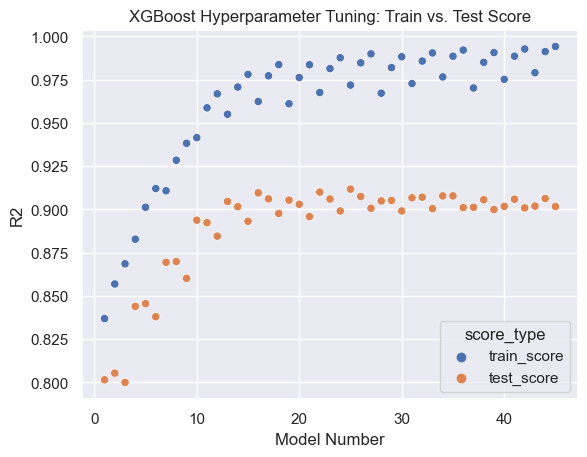

In [30]:
sns.scatterplot(data = gsCV_xgb_train_vs_test_df.loc[gsCV_xgb_train_vs_test_df['score'] > 0,:], y = 'score', x = 'model_number', hue = 'score_type')
plt.title('XGBoost Hyperparameter Tuning: Train vs. Test Score')
plt.xlabel('Model Number')
plt.ylabel('R2')

In [31]:
print('Best score: ' + str(gsCV.best_score_))
print('Best parameters: ' + str(gsCV.best_params_))


Best score: 0.9117526839256724
Best parameters: {'learning_rate': 0.1, 'n_estimators': 60, 'subsample': 0.3}


In [32]:
xgb.set_params(learning_rate = 0.1, subsample = 0.3, n_estimators = 60)
xgb.fit(X = X_train_encoded, y = np.log(y_train_encoded))
print('Best train score: ' + str(xgb.score(X = X_train_encoded,y = np.log(y_train_encoded))))
print('Best test score: ' + str(xgb.score(X = X_test_encoded,y = np.log(y_test_encoded))))


Best train score: 0.968102472698071
Best test score: 0.9210058895794686


In [33]:
xgb_encoded_tuned_train_test_score = pd.DataFrame({'Model': ['XGBoost_Encoded_Tuned'],
              'Train Score': [r2_score(np.log(y_train_encoded), xgb.predict(X_train_encoded))],
              'Test Score': [r2_score(np.log(y_test_encoded), xgb.predict(X_test_encoded))]
             })
xgb_encoded_tuned_train_test_score

,Model,Train Score,Test Score
0,XGBoost_Encoded_Tuned,0.968102,0.921006


## XGBoost - Encoded - Post Tuning - Cross Validation

In [34]:

xgb = XGBRegressor(objective ='reg:squarederror', random_state=0, learning_rate = 0.1, subsample = 0.3, n_estimators = 60)

xgb_encoded_cv_tuned = cross_val_score(estimator = xgb, X = features_encoded, y = np.log(response), cv = kf, scoring = 'r2')


In [35]:

print('Mean cross-validation score: ' + str(xgb_encoded_cv_tuned.mean()))
print('Std dev cross-validation score: ' + str(xgb_encoded_cv_tuned.std()))

Mean cross-validation score: 0.9141707873070107
Std dev cross-validation score: 0.010105312836419245


# Model Restults Export

In [36]:
xgboost_results = pd.DataFrame(data = {'Model Number': np.linspace(1,5,5),
                                      'XGBoost_Drop': xgb_drop_cv,
                                      'XGBoost_Drop_Tuned': xgb_drop_cv_tuned,
                                      'XGBoost_Encoded': xgb_encoded_cv,
                                      'XGBoost_Encoded_Tuned': xgb_encoded_cv_tuned
                                      
                                     }
                             )

xgboost_results 

,Model Number,XGBoost_Drop,XGBoost_Drop_Tuned,XGBoost_Encoded,XGBoost_Encoded_Tuned
0,1.0,0.916248,0.918594,0.913742,0.917026
1,2.0,0.901196,0.911201,0.904800,0.909091
2,3.0,0.920300,0.929849,0.911326,0.927302
3,4.0,0.906518,0.919113,0.901455,0.919780
4,5.0,0.883741,0.902878,0.887719,0.897656


In [37]:
xgb_train_test_score = pd.concat([xgb_drop_train_test_score,
           xgb_drop_tuned_train_test_score,
           xgb_encoded_train_test_score,
           xgb_encoded_tuned_train_test_score
          ])
xgb_train_test_score

,Model,Train Score,Test Score
0,XGBoost_Drop,0.998740,0.916248
0,XGBoost_Drop_Tuned,0.968274,0.920246
0,XGBoost_Encoded,0.999264,0.913742
0,XGBoost_Encoded_Tuned,0.968102,0.921006


In [38]:

current_directory = os.getcwd()

dataframes = {'xgboost_results': xgboost_results,
             'xgb_train_test_score': xgb_train_test_score
             }


for name, df in dataframes.items():

    file_path = os.path.join(current_directory, f"{name}.csv")
    
    df.to_csv(file_path, sep='\t', index=False)

# SHAP Analysis

In [39]:
xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [40]:
import shap
shap.initjs()

In [41]:
xgb.fit(X = features_encoded, y = (response))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=60, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

Text(0.5, 1.0, 'XGBoost Residuals Plot')

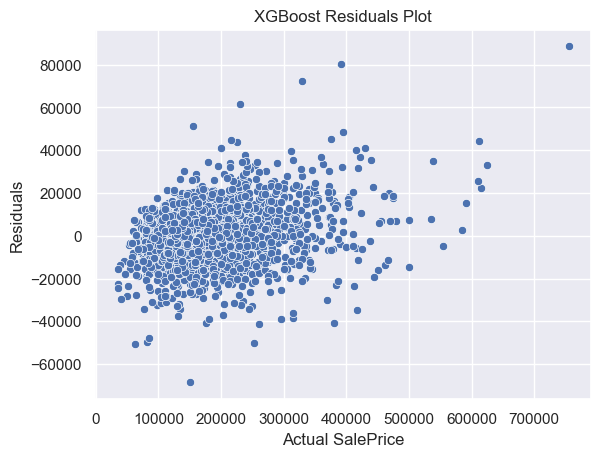

In [42]:
xgb_residuals = response['SalePrice'] - (xgb.predict(X = features_encoded)) 
xgb_residuals_df = pd.DataFrame({'Actual SalePrice': response['SalePrice'],
                                 'Predicted SalePrice': xgb.predict(X = features_encoded),
                                 'Residuals': xgb_residuals
                                })

sns.scatterplot(data = xgb_residuals_df.loc[xgb_residuals_df['Residuals'] > -150000, :], x = 'Actual SalePrice', y = 'Residuals')

plt.title('XGBoost Residuals Plot')

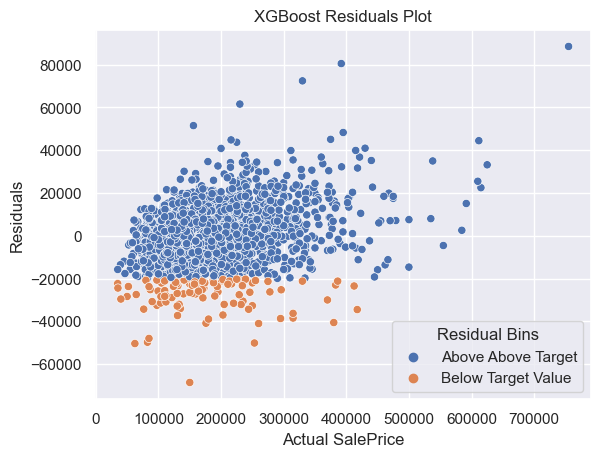

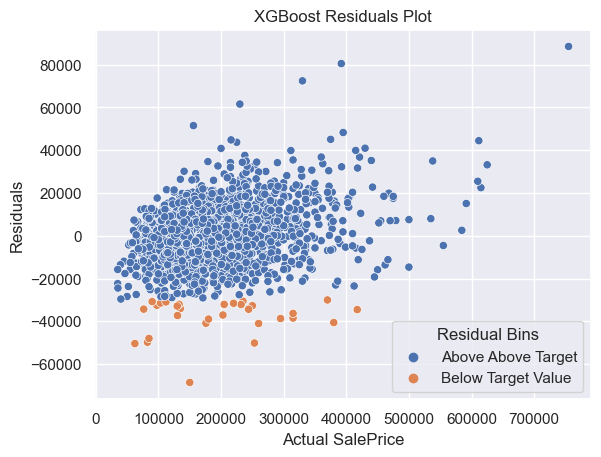

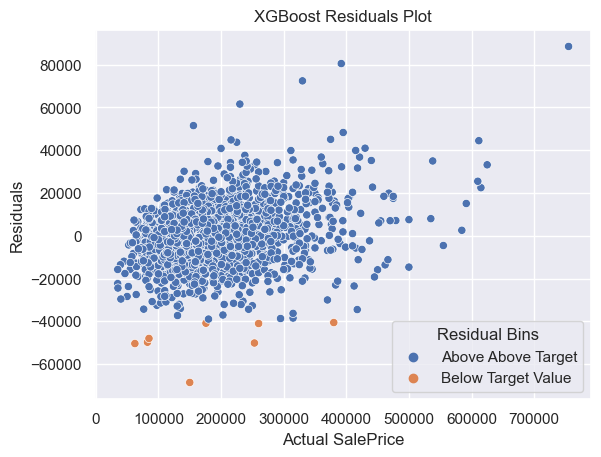

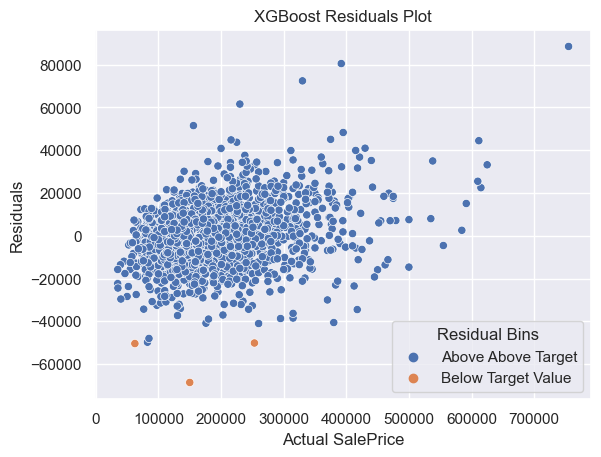

In [43]:
bins = [-20000, -30000, -40000, -50000]

for bin_num in bins:
    xgb_residuals_df['Residual Bins'] = np.where(xgb_residuals_df['Residuals'] < bin_num, 'Below Target Value', 'Above Above Target')
    sns.scatterplot(data = xgb_residuals_df.loc[xgb_residuals_df['Residuals'] > -150000, :], x = 'Actual SalePrice', y = 'Residuals', hue= 'Residual Bins')
    plt.title('XGBoost Residuals Plot')
    plt.show()

In [44]:
features_responses_actual_predicted_df = pd.concat([features, xgb_residuals_df], axis = 1)
features_responses_actual_predicted_df

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF,HighQualFinSF,BsmtFinSF,YearsBetweenBuildvsRemod,TotalFullBath,TotalHalfBath,TotalPorch_DeckSF,YearsBetweenBuildvsSold,YearsBetweenRemodvsSold,Actual SalePrice,Predicted SalePrice,Residuals,Residual Bins
0,856,30,RL,68.510628,7890,Pave,No alley access,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,No Pool,No Fence,NaN,0,3,2010,WD,Normal,1712.0,1712.0,238.0,11,2.0,0.0,166,71,60,126000,124328.781250,1671.218750,Above Above Target
1,1049,120,RL,42.000000,4235,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,No Fireplace,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,No Pool,No Fence,NaN,0,2,2009,WD,Normal,2098.0,2098.0,945.0,0,3.0,0.0,105,25,25,139500,138780.343750,719.656250,Above Above Target
2,1001,30,C (all),60.000000,6060,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,No Fireplace,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,No Pool,No Fence,NaN,0,11,2007,WD,Normal,1838.0,1838.0,737.0,77,1.0,0.0,282,77,0,124900,130206.148438,-5306.148438,Above Above Target
3,1039,70,RL,80.000000,8146,Pave,No alley access,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,No Fireplace,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,No Pool,No Fence,NaN,0,5,2009,WD,Normal,1444.0,1444.0,0.0,103,1.0,0.0,279,109,6,114000,108552.367188,5447.632812,Above Above Target
4,1665,60,RL,70.000000,8400,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,No Fireplace,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,No Pool,No Fence,NaN,0,11,2009,WD,Normal,2475.0,2475.0,643.0,0,3.0,1.0,45,8,8,227000,208523.296875,18476.703125,Above Above Target
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,952,30,RL,68.510628,8854,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1.5Unf,6,6,1916,1950,Gable,CompShg,Wd Sdng,Wd Sdng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,Grav,Fa,N,FuseF,952,0,0,0.0,0.0,1,0,2,1,Fa,4,Typ,1,Gd,Detchd,1916.0,Unf,1.0,192.0,

Text(0, 0.5, 'Actual SalePrice')

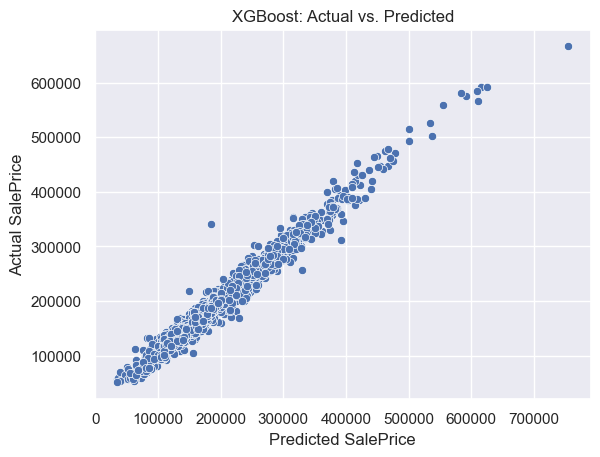

In [45]:
sns.scatterplot(data = features_responses_actual_predicted_df, x = 'Actual SalePrice', y = 'Predicted SalePrice')
plt.title('XGBoost: Actual vs. Predicted')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Actual SalePrice')

## Below predicted value by $30,000 and no fireplaces

In [46]:
features_responses_actual_predicted_df['Criteria'] = np.where((features_responses_actual_predicted_df['Fireplaces'] == 0) & (features_responses_actual_predicted_df['Residuals'] < -30000),
                                                            'Yes',
                                                            'No'
                                                           )


In [47]:
features_responses_actual_predicted_df['Criteria'].value_counts()                             


Criteria
No     2571
Yes       7
Name: count, dtype: int64

Text(0.5, 1.0, 'XGBoost Residuals Plot')

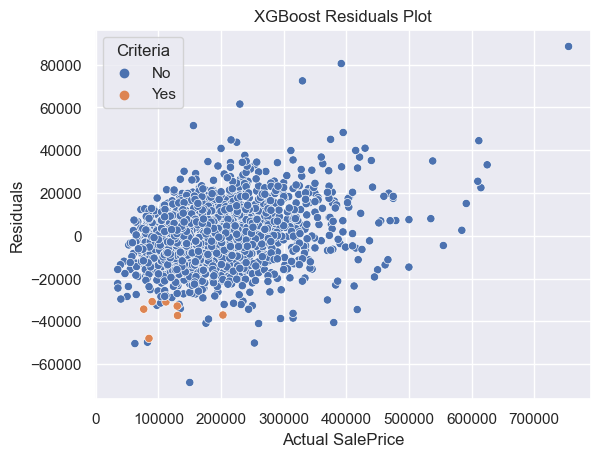

In [48]:

sns.scatterplot(data = features_responses_actual_predicted_df.loc[features_responses_actual_predicted_df['Residuals'] > -150000, :],
                x = 'Actual SalePrice', y = 'Residuals', hue = 'Criteria')

# sns.scatterplot(x = xgb_residuals.index, y = xgb_residuals)
plt.title('XGBoost Residuals Plot')

## Below predicted value by $30,000 and OverallQual is 7


In [49]:
features_responses_actual_predicted_df['Criteria'] = np.where((features_responses_actual_predicted_df['OverallQual'] == 7) & (features_responses_actual_predicted_df['Residuals'] < -30000),
                                                            'Yes',
                                                            'No'
                                                           )


In [50]:
features_responses_actual_predicted_df['Criteria'].value_counts()                             


Criteria
No     2570
Yes       8
Name: count, dtype: int64

Text(0.5, 1.0, 'XGBoost Residuals Plot')

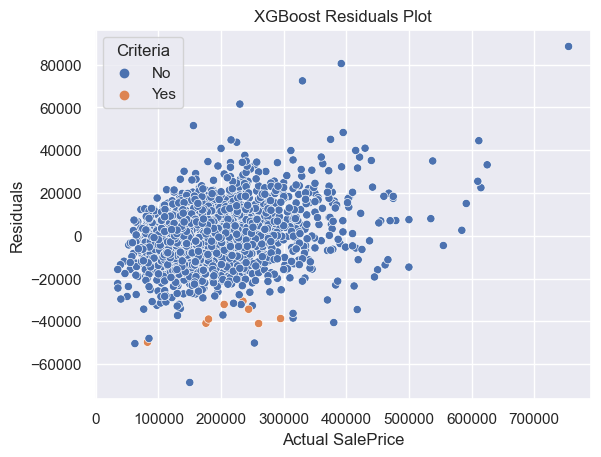

In [51]:

sns.scatterplot(data = features_responses_actual_predicted_df.loc[features_responses_actual_predicted_df['Residuals'] > -150000, :], 
                x = 'Actual SalePrice', y = 'Residuals', hue = 'Criteria')

# sns.scatterplot(x = xgb_residuals.index, y = xgb_residuals)
plt.title('XGBoost Residuals Plot')

## Below predicted value by $30,000 and HighQualFinSF is 2750


In [52]:
features_responses_actual_predicted_df['Criteria'] = np.where((features_responses_actual_predicted_df['HighQualFinSF'] > 2500) & (features_responses_actual_predicted_df['Residuals'] < -30000),
                                                            'Yes',
                                                            'No'
                                                           )


In [53]:
features_responses_actual_predicted_df['Criteria'].value_counts()                             


Criteria
No     2553
Yes      25
Name: count, dtype: int64

## SHAP visualizations

In [54]:
shap_model = xgb.fit(X = features_encoded, y = (response))

In [55]:
explainer = shap.TreeExplainer(shap_model)
shap_values = explainer(features_encoded)

In [56]:
features_encoded.shape

(2578, 88)

In [57]:
np.shape(shap_values.values)

(2578, 88)

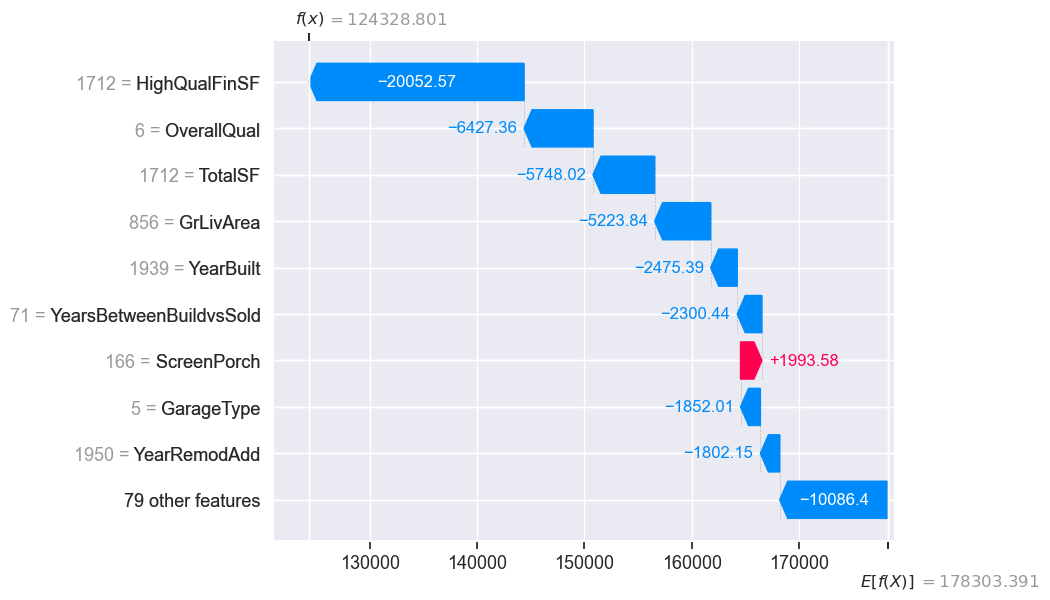

In [58]:
shap.plots.waterfall(shap_values[0])

# E[f(x)] is the average prediction
# Bars are the SHAP values
# f(x) is the predicted sale price

In [59]:
shap.plots.force(shap_values[0])

In [60]:
shap.plots.force(shap_values[0:100])

# relationship between variable and response

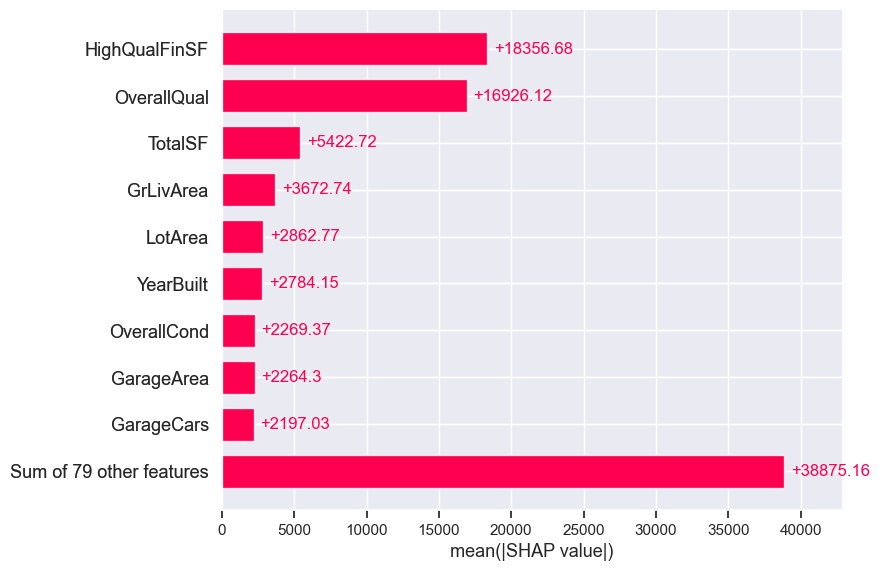

In [61]:
shap.plots.bar(shap_values)

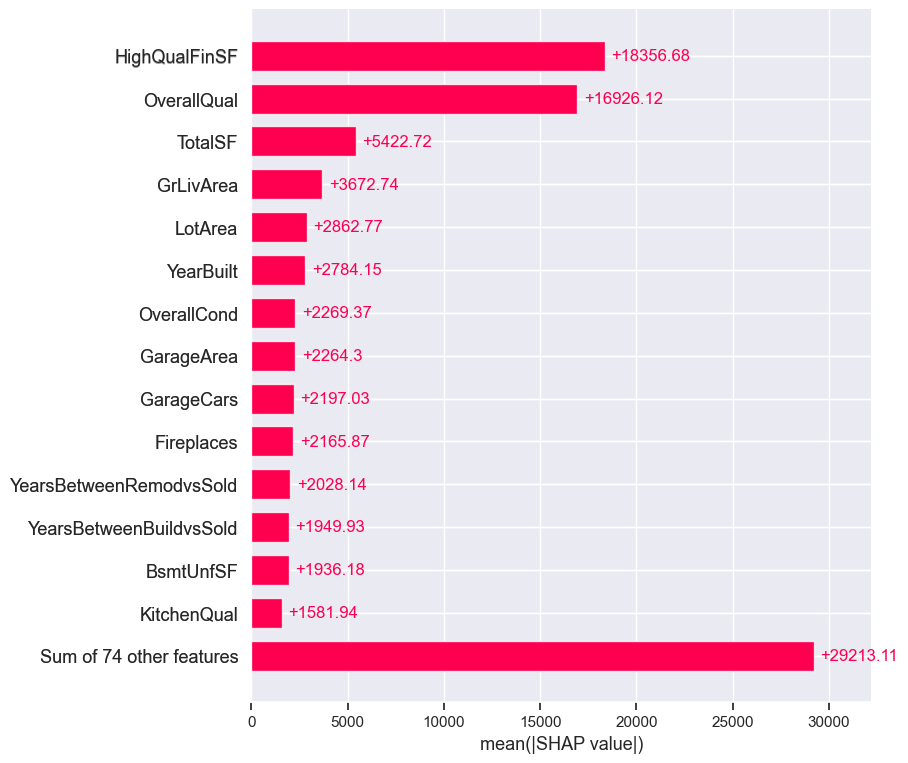

In [62]:
shap.plots.bar(shap_values, max_display = 15)

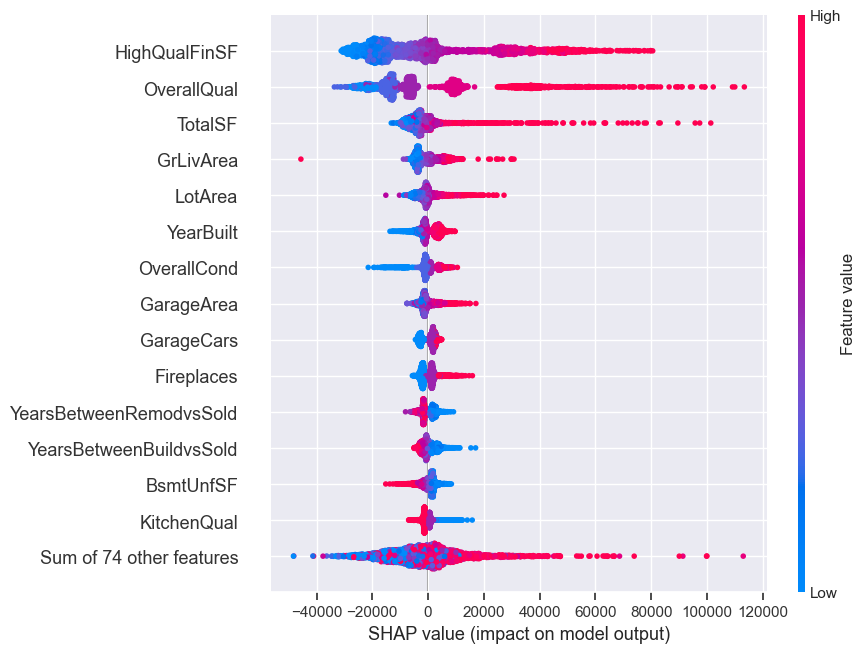

In [63]:
shap.plots.beeswarm(shap_values, max_display = 15)

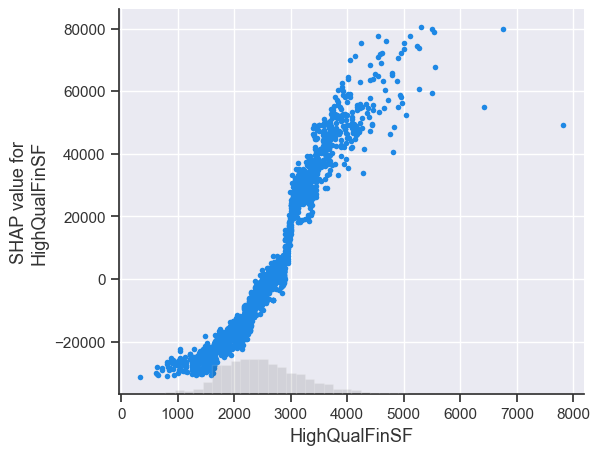

In [64]:
shap.plots.scatter(shap_values[:,'HighQualFinSF'])

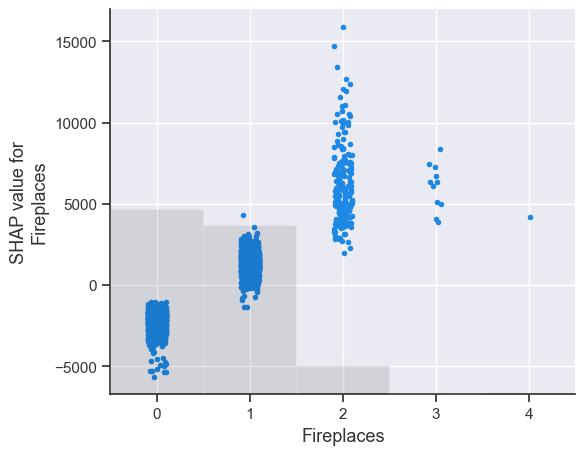

In [65]:
shap.plots.scatter(shap_values[:,'Fireplaces'])

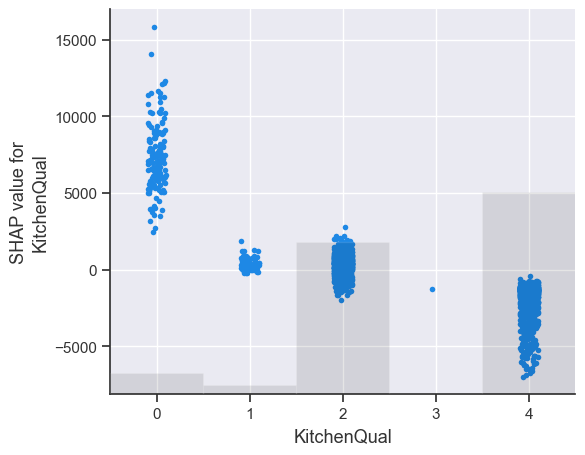

In [66]:
shap.plots.scatter(shap_values[:,'KitchenQual'])

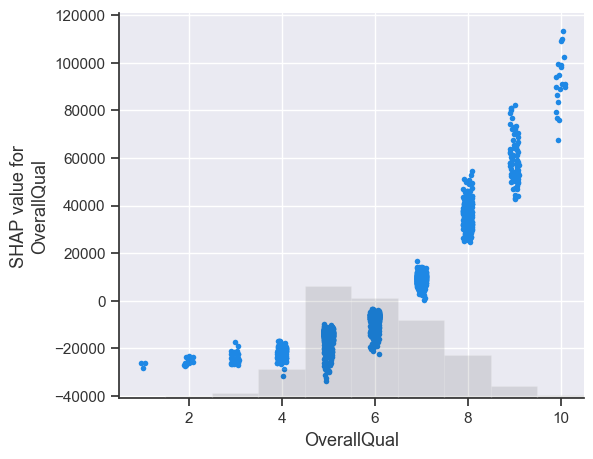

In [67]:
shap.plots.scatter(shap_values[:,'OverallQual'])

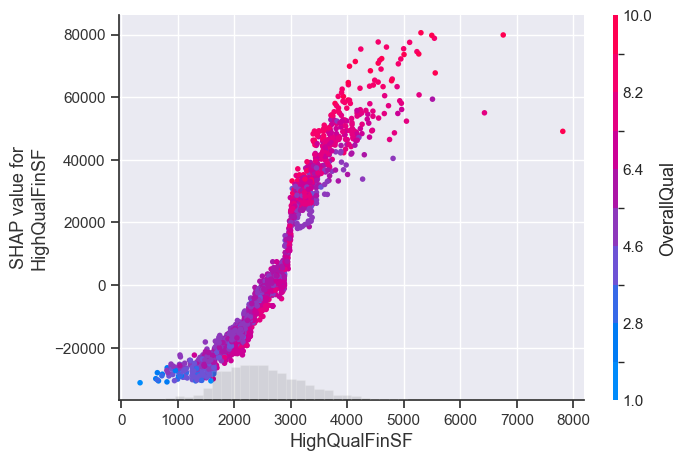

In [68]:
shap.plots.scatter(shap_values[:,'HighQualFinSF'],
                  color = shap_values[:,'OverallQual'])

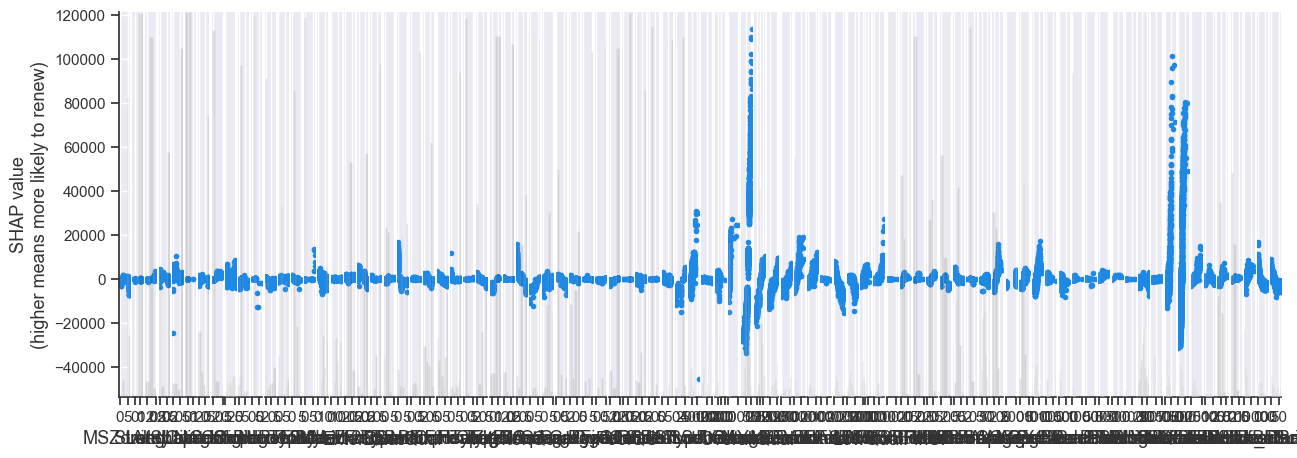

In [69]:
shap.plots.scatter(
    shap_values, ylabel="SHAP value\n(higher means more likely to renew)"
)

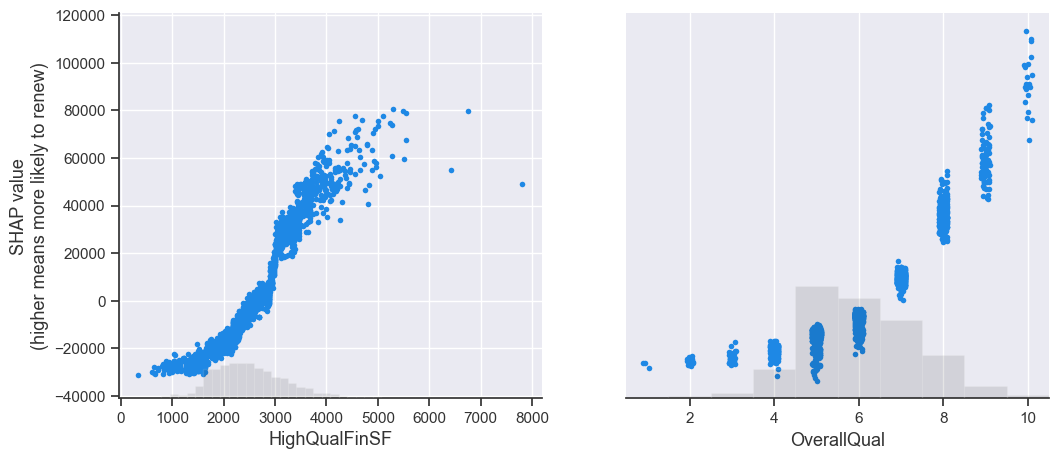

In [70]:

# Calculate the sum of absolute SHAP values for each feature
shap_sum = np.abs(shap_values.values).mean(0)

# Get the indices of the top 10 features with the highest SHAP sum
top_2_indices = np.argsort(shap_sum)[::-1][:2]

# Select the SHAP values for the top 10 features
top_2_shap_values = shap_values[:, top_2_indices]

# Plot the scatter plot for the top 10 features
shap.plots.scatter(top_2_shap_values, ylabel="SHAP value\n(higher means more likely to renew)")


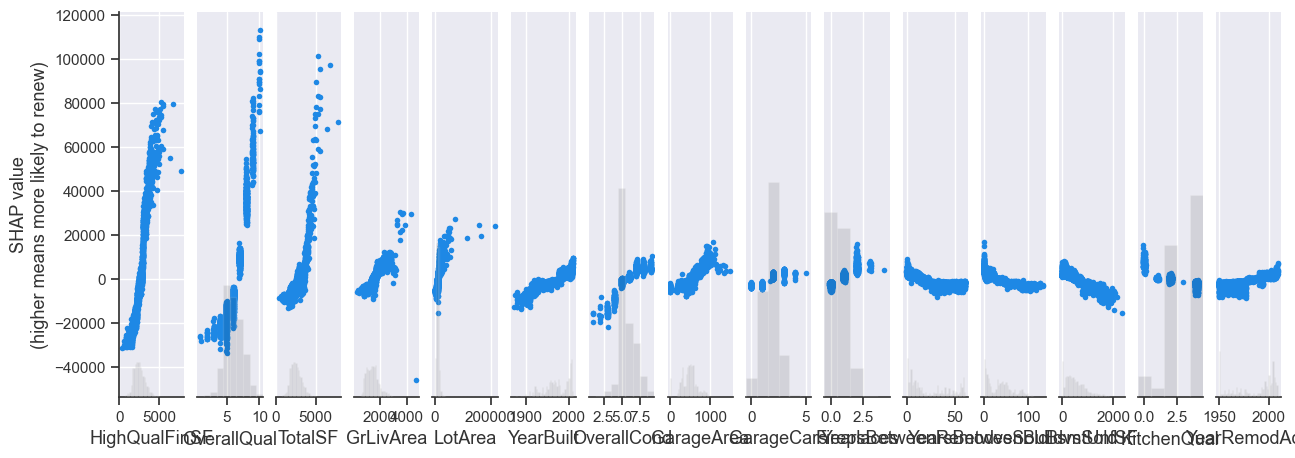

In [71]:

# Calculate the sum of absolute SHAP values for each feature
shap_sum = np.abs(shap_values.values).mean(0)

# Get the indices of the top 10 features with the highest SHAP sum
top_15_indices = np.argsort(shap_sum)[::-1][:15]

# Select the SHAP values for the top 10 features
top_15_shap_values = shap_values[:, top_15_indices]

# Plot the scatter plot for the top 10 features
shap.plots.scatter(top_15_shap_values, ylabel="SHAP value\n(higher means more likely to renew)")


In [72]:
features.loc[:, 'KitchenQual'].value_counts()

KitchenQual
TA    1356
Gd    1017
Ex     142
Fa      62
Po       1
Name: count, dtype: int64

In [73]:
features_encoded.loc[:, 'KitchenQual'].value_counts()

KitchenQual
4    1356
2    1017
0     142
1      62
3       1
Name: count, dtype: int64